# Q1 Data Wrangling and Cleaning
To keep things simple I restrict the dataset to Fannie Mae's Single-Family [Data](https://www.fhfa.gov/DataTools/Downloads/Pages/Public-Use-Databases.aspx) within the year 2017. Confining the data to such a small period is fine for my purposes because I do not aim to create a final model that can be used to accurately predict mortgage defaults, but rather see if machine learning models outperform the traditional logit model when predicting loan defaults. 

[Reference](http://www.fanniemae.com/resources/file/fundmarket/pdf/webinar-101.pdf)

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from imblearn.over_sampling import SMOTE

%matplotlib inline

The data is divided into acquisition data, and performance data and presented by quarter. For the sake of visualizing examples I will create a small dataset with just the first quarter. I will developed the models using the data from the full year.

In [2]:
# Acquisition Data Column Names
acq_columns = ['LoanID','Channel','SellerName','OrInterestRate','OrUPB','OrLoanTerm',
        'OrDate','FirstPayDate','OrLTV','OrCLTV','NumBorrow','OrDTIRat','OrCreditScore',
        'FTHomeBuyer','LoanPurpose','PropertyType','NumUnits','OccStatus','PropertyState',
        'Zip','MortInsPerc','ProductType','CoCreditScore','MortInsType','RelMortInd'];
# Performance Data Column Names
per_columns = ['LoanID','MonthRep','Servicer','CurrInterestRate','CAUPB','LoanAge','MonthsToMaturity',
          'AdMonthsToMaturity','MaturityDate','MSA','CLDS','ModFlag','ZeroBalCode','ZeroBalDate',
          'LastPayDate','ForeDate','DispDate','PPRC','AssetRecCost','MHRC',
          'ATFHP','NetSaleProceeds','CreditEnhProceeds','RPMWP','OFP','NIBUPB','PFA','RMWPF',
          'FPWA','ServicingIndicator'];

In [3]:
# Read in Data
acq2017q1 = pd.read_csv("Acquisition_2017Q1.txt", sep = '|', header=None, names=acq_columns, index_col=False)
per2017q1 = pd.read_csv("Performance_2017Q1.txt", sep = '|', header=None, names=per_columns, usecols=[0,15],index_col=False)

/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3049: DtypeWarning: Columns (15) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [4]:
# Keep only the last report every loan in performance (We only care about default)
per2017q1.drop_duplicates(subset='LoanID', keep='last', inplace=True)
quarter1 = pd.merge(acq2017q1, per2017q1, on="LoanID", how="inner")

# Create a dummy variable to track if the loan defaulted or not
quarter1['Default'] = quarter1['ForeDate'].fillna(0, inplace = False)
quarter1.loc[quarter1['Default'] != 0, 'Default'] = 1
quarter1['Default'] = quarter1['Default'].astype(int)

In [5]:
quarter1.head()

,LoanID,Channel,SellerName,OrInterestRate,OrUPB,OrLoanTerm,OrDate,FirstPayDate,OrLTV,OrCLTV,...,OccStatus,PropertyState,Zip,MortInsPerc,ProductType,CoCreditScore,MortInsType,RelMortInd,ForeDate,Default
0,100002130634,R,QUICKEN LOANS INC.,4.375,159000,360,12/2016,02/2017,62,62,...,P,CO,804,NaN,FRM,701.0,NaN,N,NaN,0
1,100003080256,B,"UNITED SHORE FINANCIAL SERVICES, LLC D/B/A UNI...",4.875,94000,360,02/2017,04/2017,75,75,...,I,CT,60,NaN,FRM,723.0,NaN,N,NaN,0
2,100003722619,R,QUICKEN LOANS INC.,3.875,113000,240,12/2016,02/2017,75,75,...,I,TN,370,NaN,FRM,NaN,NaN,N,NaN,0
3,100004837443,R,OTHER,3.500,198000,360,01/2017,03/2017,33,33,...,P,CA,950,NaN,FRM,NaN,NaN,N,NaN,0
4,100007361597,C,OTHER,3.625,94000,360,12/2016,02/2017,67,67,...,P,AR,729,NaN,FRM,NaN,NaN,N,NaN,0


In [6]:
n = quarter1.shape[1]
quarter1.shape

(480198, 27)

There do not appear to be many defaults so I will attempt to balance the data using SMOTE. I will do this and explain it in the explanatory notebook.

In [7]:
defaults = quarter1.groupby('Default').size()
defaults

Default
0    480136
1        62
dtype: int64

There are 6 variables with missing values: Original Debt-to-Income Ratio, Original Credit Score, Mortgage Insurance Percent, Foreclosure Date.

In [8]:
ndflt = quarter1[quarter1['Default'] == 0].isna().sum()
dflt = quarter1[quarter1['Default'] == 1].isna().sum()
nans = pd.DataFrame({ "0" : ndflt, "1" : dflt})
nans = nans[(nans.T != 0).any()]
nans['Ratio NaNs/NDflts'] = nans['0']/defaults[0]
nans['Ratio NaNs/Dflts'] = nans["1"]/defaults[1]
p = nans['Ratio NaNs/NDflts']
q = nans['Ratio NaNs/Dflts']
nans['Z-Score'] = (p - q)/np.sqrt( ((p*(1-p))/ndflt) + ((q*(1-q))/dflt) )
nans

,0,1,Ratio NaNs/NDflts,Ratio NaNs/Dflts,Z-Score
OrDTIRat,60,0,0.000125,0.000000,NaN
OrCreditScore,276,0,0.000575,0.000000,NaN
MortInsPerc,357327,21,0.744220,0.338710,3.926370
CoCreditScore,249415,46,0.519467,0.741935,-3.447841
MortInsType,357327,21,0.744220,0.338710,3.926370
ForeDate,480136,0,1.000000,0.000000,NaN


I will drop Foreclosure date completely because I've already used it for my purposes.

I'm going to drop observations with NaNs for Original Debt-to-Loan Ratio and Original Credit Score because they appear to be insignificant. 

The prescence of mortgage insurance and a co-creditor appears to be significant. 

For the two mortgage variables, I can fill the NaNs with 0. This will make sense because models will read it as the lack of mortgage insurance. 

With co-borrowers credit score, to account for the NaNs I will create a dummy variable coded as 1 for NaN and 0 otherwise. I will fill the NaNs in CoCreditScore with the mean. There is a lot of discussion on how to treat this type of missing data, but I think the mean will do fine for this purpose.

In [9]:
# Drop ForeDate
quarter1 = quarter1.drop('ForeDate', axis=1)
# Drop the insignificant missing observations
quarter1 = quarter1.dropna(subset=['OrDTIRat', 'OrCreditScore'])
# Fill Mortgage Insurance with 0
quarter1["MortInsPerc"] = quarter1["MortInsPerc"].fillna(0)
quarter1["MortInsType"] = quarter1["MortInsType"].fillna(0)
# CoCreditScore create dummy variable for NaNs, fill NaNs with Mean
quarter1["CoCreditor"] = np.where(quarter1['CoCreditScore'].isna(), 1, 0)
quarter1['CoCreditScore'] = np.where(quarter1['CoCreditScore'].isna(), 
                                     quarter1['CoCreditScore'].mean(), 
                                     quarter1['CoCreditScore']
                                    )

We should check for missing data with other columns with simple histograms.

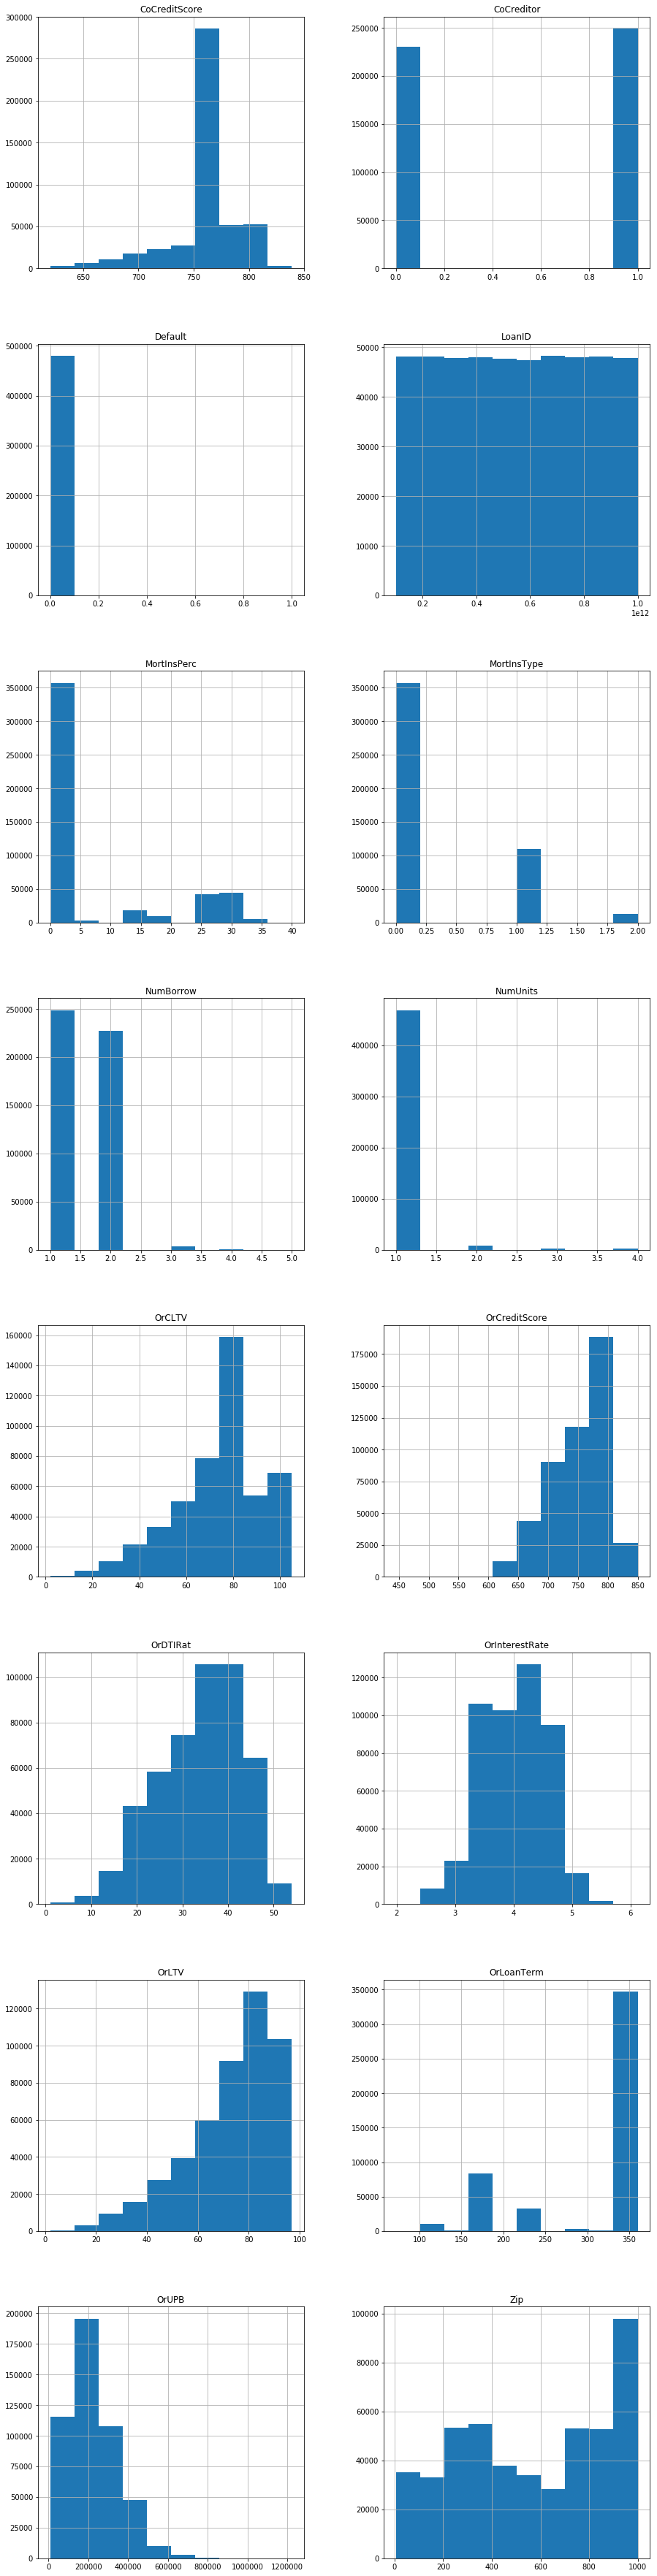

In [10]:
fig, ax = plt.subplots(8, 2, figsize=(15, 4*16))
quarter1.hist(ax=ax)
plt.show()

There does not appear to be any other missing value instances. I'll write out the data as clean data.

In [11]:
quarter1.to_csv("Q1_clean.csv")